# Postprocess locations from DLC and a video

## First, read the locations from DLC

In [1]:
# 
import h5py
import os
import matplotlib.pyplot as plt

In [2]:
def xy_from_dlc_dat(fname, which_neuron=0, num_frames=100):

    xy_ind = range(which_neuron*3, which_neuron*3 + 2)
    prob_ind = which_neuron*3 + 2

    this_xy = []
    this_prob = []

    with h5py.File(fname, 'r') as dlc_dat:
        dlc_table = dlc_dat['df_with_missing']['table']
        which_frames = range(num_frames)
        this_xy.extend([this_frame[1][xy_ind] for this_frame in dlc_table[which_frames]])
        this_prob.extend([this_frame[1][prob_ind] for this_frame in dlc_table[which_frames]])
    
    return this_xy, this_prob

In [10]:
# Raw video
# folder_name = '/users/charles.fieseler/test_worm1_data/mCherry_slices_long/'
# fname = 'test_1000frames_13sliceDLC_resnet50_WormTestJul16shuffle1_34000.h5'
# fname = os.path.join(folder_name, fname)

# Pre-aligned (within volumes)
folder_name = '/users/charles.fieseler/test_worm1_data/mCherry_volume_aligned/'
# fname = 'test_100frames_13sliceDLC_resnet50_volume_aligned_aviJul20shuffle1_5500.h5'
fname = 'test_100frames_13sliceDLC_resnet50_volume_aligned_aviJul20shuffle1_4500.h5' # Tightened training
annotation_fname = os.path.join(folder_name, fname)

this_xy, this_prob = xy_from_dlc_dat(annotation_fname, which_neuron=0, num_frames=100)

Text(0.5, 1.0, 'Confidence')

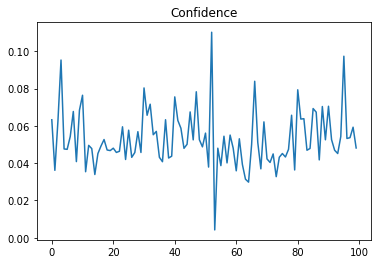

In [11]:
plt.plot(this_prob)
plt.title('Confidence')

## Second, get a moving crop centering this neuron

In [12]:
import numpy as np
import cv2
import torch
import tifffile

In [13]:
def get_crop_coords(center, sz=(28,28)):
    x_ind = range(int(center[0] - sz[0]/2), int(center[0] + sz[0]/2))
    y_ind = range(int(center[1] - sz[1]/2), int(center[1] + sz[1]/2))
    return list(x_ind), list(y_ind)

In [14]:
def get_crop_from_avi(fname, num_frames, sz=(28,28)):

    cap = cv2.VideoCapture(fname)

    # Pre-allocate in proper size for future
    cropped_dat = np.zeros(sz+(1,num_frames))
    all_dat = []

    for i in range(num_frames):
        ret, frame = cap.read()

        x_ind, y_ind = get_crop_coords(this_xy[i], sz)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        try:
            cropped = gray[:,x_ind][y_ind]
            cropped_dat[:,:,0,i] = cropped / np.max(cropped)
        except:
            continue

    cap.release()
    
    return cropped_dat

In [37]:
folder_name = '/users/charles.fieseler/test_worm1_data/mCherry_volume_aligned/'
fname = 'test_100frames_13slice.avi'
video_fname = os.path.join(folder_name, fname)

num_frames = 100
sz=(29,29)

cropped_dat = get_crop_from_avi(video_fname, num_frames, sz=sz)

In [38]:
from ipywidgets import interact, interactive, fixed, interact_manual
f = lambda i : plt.imshow(cropped_dat[:,:,0,i])
interact(f, i=(0,num_frames-1))

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(i)>

## Run dNMF

In [39]:
from dNMF.Demix.dNMF import dNMF
import time

In [40]:
# %% Choosing the parameters
params = {'n_trials':5, 'noise_level':1e-2, 'sigma_inv':.2, 
          'radius':10, 'step_S':.1, 'gamma':0, 'stride_factor':2, 'density':.1, 'varfact':5,
          'traj_means':[.0,.0,.0], 'traj_variances':[2e-4,2e-4,1e-5], 'sz':[20,20,1], 
          'K':20, 'T':100, 'roi_window':[4,4,0]}

In [41]:
# Build position and convert to pytorch
positions =[list(sz + (0,)),[0, 0, 0]] # Add a dummy position
positions = np.expand_dims(positions,2)/2.0 # Return the center of the crop
positions =  torch.tensor(positions).float()

# Also convert video to pytorch
dat = torch.tensor(cropped_dat).float()

In [42]:
print(positions.shape)
print((positions[:,:,0][:,:,np.newaxis]).shape)
print(positions[:,:,0].shape)
print(positions)

torch.Size([2, 3, 1])
torch.Size([2, 3, 1])
torch.Size([2, 3])
tensor([[[14.5000],
         [14.5000],
         [ 0.0000]],

        [[ 0.0000],
         [ 0.0000],
         [ 0.0000]]])


In [43]:
start = time.time()
# Initialize using the following from the ground truth:
#  Initial positions
#  Radius
#  
dnmf = dNMF(dat,params={'positions':positions[:,:,0][:,:,np.newaxis],\
    'radius':params['radius'],'step_S':params['step_S'],'gamma':params['gamma'],\
    'use_gpu':False,'initial_p':positions[:,:,0],'sigma_inv':params['sigma_inv'],\
    'method':'1->t', 'verbose':False})

dnmf.optimize(lr=1e-4,n_iter=20,n_iter_c=2)
end = time.time()
print('dNMF finished in ' + str(end-start) + ' seconds')

/users/charles.fieseler/dNMF_parent/dNMF/Demix/dNMF.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor(params['scale']).float().to(device=device).squeeze() # microns per pixel


dNMF finished in 17.914485454559326 seconds


# Plot trace

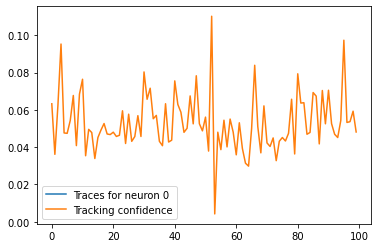

In [44]:
which_neuron = 0

plt.plot(dnmf.C[which_neuron,:])
# plt.legend('dNMF')
plt.plot(this_prob)
plt.legend(('Traces for neuron {}'.format(which_neuron), 'Tracking confidence'))
plt.savefig('Traces for neuron {}'.format(which_neuron))

/users/charles.fieseler/dNMF_parent/dNMF/WUtils/Utils.py:35: RuntimeWarning: overflow encountered in long_scalars
  patch = cube[loc[0]-rel[0]: loc[0]+reu[0]+1,loc[1]-rel[1]: loc[1]+reu[1]+1,loc[2]-rel[2]: loc[2]+reu[2]+1,:]


ValueError: index can't contain negative values

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


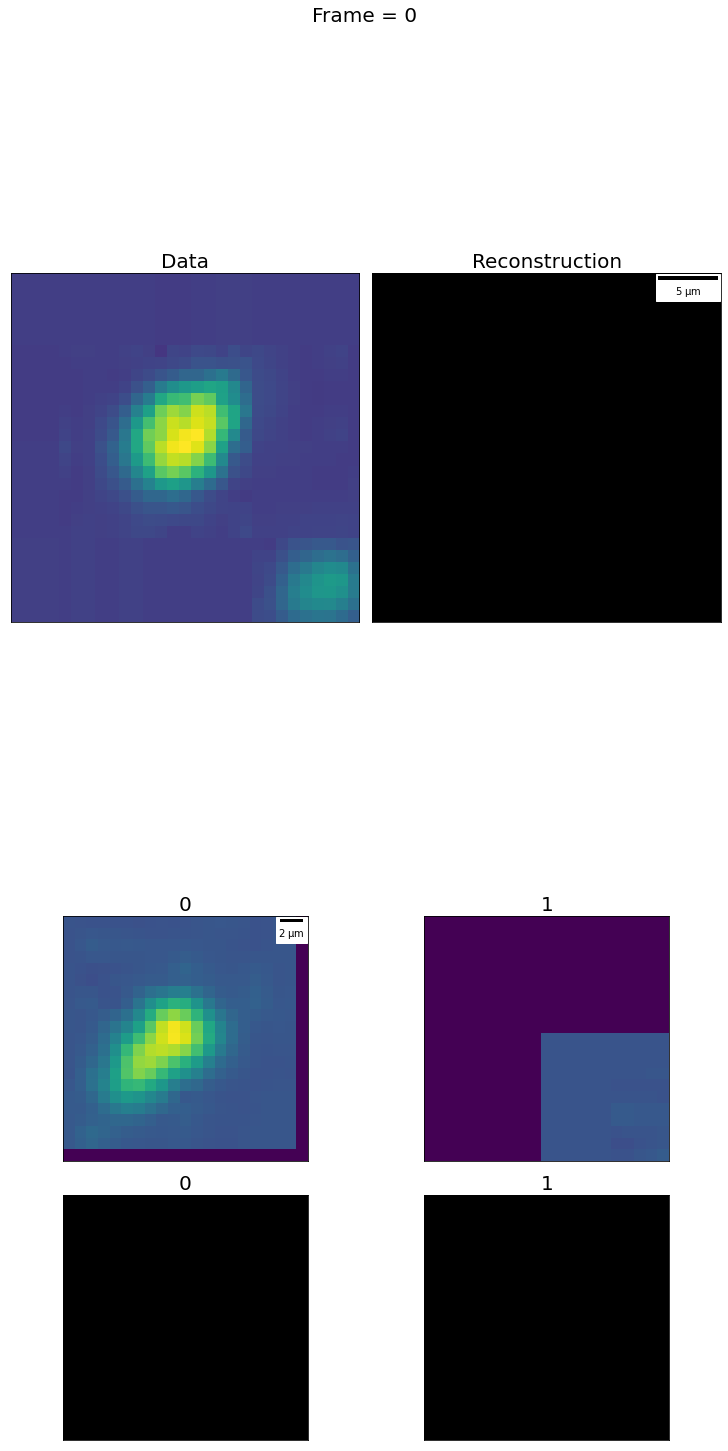

In [46]:
neuron_names = [str(i) for i in range(positions.shape[0])]

dnmf.visualize_neurons('result', [['0','1']], neuron_names, dat)

In [47]:
dnmf.visualize_tracks('result',dat)

In [25]:
dnmf.visualize_stats('result')

/users/charles.fieseler/.conda/envs/dNMF/lib/python3.7/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/users/charles.fieseler/.conda/envs/dNMF/lib/python3.7/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/users/charles.fieseler/.conda/envs/dNMF/lib/python3.7/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/users/charles.fieseler/.conda/envs/dNMF/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [19]:
# dnmf.visualize_traces('result', dnmf.C, neuron_names)

# Try 2: Get a 3d cube around the DLC track

In [48]:
import numpy as np
import cv2
import torch
import tifffile
import os

In [49]:
def get_crop_coords3d(center, crop_sz=(28,28,10), clip_sz=None):
    x_ind = range(int(center[0] - crop_sz[0]/2), int(center[0] + crop_sz[0]/2))
    y_ind = range(int(center[1] - crop_sz[1]/2), int(center[1] + crop_sz[1]/2))
    z_ind = range(int(center[2] - crop_sz[2]/2), int(center[2] + crop_sz[2]/2))
#     return list(x_ind), list(y_ind), list(z_ind)
    if clip_sz is not None:
#         x_ind = np.fmin(np.fmax(x_ind, 0), clip_sz[0])
#         y_ind = np.fmin(np.fmax(y_ind, 0), clip_sz[1])
#         z_ind = np.fmin(np.fmax(z_ind, 0), clip_sz[2])
        x_ind = np.clip(x_ind, 0, clip_sz[0])
        y_ind = np.clip(y_ind, 0, clip_sz[1])
        z_ind = np.clip(z_ind, 0, clip_sz[2])
    return np.array(x_ind), np.array(y_ind), np.array(z_ind)

def get_crop_coords3d_old(center, crop_sz=(28,28,10), clip_sz=None):
    x_ind = (int(center[0] - crop_sz[0]/2), int(center[0] + crop_sz[0]/2))
    y_ind = (int(center[1] - crop_sz[1]/2), int(center[1] + crop_sz[1]/2))
    z_ind = (int(center[2] - crop_sz[2]/2), int(center[2] + crop_sz[2]/2))
#     return list(x_ind), list(y_ind), list(z_ind)
    if clip_sz is not None:
        x_ind = np.clip(x_ind, 0, clip_sz[0])
        y_ind = np.clip(y_ind, 0, clip_sz[1])
        z_ind = np.clip(z_ind, 0, clip_sz[2])
    return x_ind, y_ind, z_ind

In [96]:
def get_crop_from_ometiff(fname, which_z, num_frames, crop_sz=(28,28,10)):

    # Pre-allocate in proper size for future
    cropped_dat = np.zeros(crop_sz+(num_frames,))
    all_dat = []
    
    print("Reading video...")
#     k = list(range(num_frames))
#     video = tifffile.imread(fname,key=k)
    video = tifffile.imread(fname)
    
    tmp = video.shape[1:]
    video_sz = (tmp[1], tmp[2], tmp[0]) # Original size is ZXY
    for i in range(num_frames):
        print(f"Reading frame {i}/{num_frames-1}")

        xyz = np.append(this_xy[i], which_z)
        x_ind, y_ind, z_ind = get_crop_coords3d(xyz, crop_sz=crop_sz, clip_sz=video_sz)
#         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        tmp = np.transpose(video[i,:,:,:][z_ind,:,:][:, y_ind,:][:,:, x_ind], axes=(1,2,0))
#         tmp = np.transpose(video[i,z_ind[0]:z_ind[1],x_ind[0]:x_ind[1],y_ind[0]:y_ind[1]], axes=(1,2,0))
        cropped_dat[:,:,:,i] = tmp
#         if tmp.shape == crop_sz:
#             cropped_dat[:,:,:,i] = tmp / np.max(tmp)
#         else:
#             print(f"Skipping frame {i}; too close to edge")
            # keep as zeros

    return cropped_dat

In [138]:
folder_name = '/users/charles.fieseler/test_worm1_data/mCherry_volume_aligned/'
fname = 'test_100frames.ome.tiff'
video3d_fname = os.path.join(folder_name, fname)

# Get a different neuron
which_neuron = 6
this_xy, this_prob = xy_from_dlc_dat(annotation_fname, which_neuron=which_neuron, num_frames=100)

which_z = 13 # The actually tracked slice
num_frames = 50
sz=(29,29,9)
cropped_dat = get_crop_from_ometiff(video3d_fname, which_z, num_frames, sz)

Reading video...
Reading frame 0/49
Reading frame 1/49
Reading frame 2/49
Reading frame 3/49
Reading frame 4/49
Reading frame 5/49
Reading frame 6/49
Reading frame 7/49
Reading frame 8/49
Reading frame 9/49
Reading frame 10/49
Reading frame 11/49
Reading frame 12/49
Reading frame 13/49
Reading frame 14/49
Reading frame 15/49
Reading frame 16/49
Reading frame 17/49
Reading frame 18/49
Reading frame 19/49
Reading frame 20/49
Reading frame 21/49
Reading frame 22/49
Reading frame 23/49
Reading frame 24/49
Reading frame 25/49
Reading frame 26/49
Reading frame 27/49
Reading frame 28/49
Reading frame 29/49
Reading frame 30/49
Reading frame 31/49
Reading frame 32/49
Reading frame 33/49
Reading frame 34/49
Reading frame 35/49
Reading frame 36/49
Reading frame 37/49
Reading frame 38/49
Reading frame 39/49
Reading frame 40/49
Reading frame 41/49
Reading frame 42/49
Reading frame 43/49
Reading frame 44/49
Reading frame 45/49
Reading frame 46/49
Reading frame 47/49
Reading frame 48/49
Reading frame

In [139]:
from ipywidgets import interact, interactive, fixed, interact_manual
f = lambda z, t : plt.imshow(cropped_dat[:,:,z,t])
interact(f, **{'t':(0,num_frames-1), 'z':(0,sz[2]-1)})

interactive(children=(IntSlider(value=4, description='z', max=8), IntSlider(value=24, description='t', max=49)…

<function __main__.<lambda>(z, t)>

In [140]:
# Then do dNMF
from dNMF.Demix.dNMF import dNMF
import time

In [141]:
# Build position and convert to pytorch
# sz=(28,28,10)
positions =[list(sz),[0, 0, 0]] # Add a dummy position
positions = np.expand_dims(positions,2)/2.0 # Return the center of the crop
positions =  torch.tensor(positions).float()
print(positions)
print(positions.shape)

tensor([[[14.5000],
         [14.5000],
         [ 4.5000]],

        [[ 0.0000],
         [ 0.0000],
         [ 0.0000]]])
torch.Size([2, 3, 1])


In [142]:
# Also convert video to pytorch
dat = torch.tensor(cropped_dat).float()
dat.shape

torch.Size([29, 29, 9, 50])

In [143]:
# %% Choosing the parameters
params = {'sigma_inv':.2, 
          'radius':4, 
          'step_S':.1, 
          'gamma':0}

start = time.time()
# Initialize using the following from the ground truth:
#  Initial positions
#  Radius
#  
# dnmf = dNMF(dat)
dnmf = dNMF(dat,params={'positions':positions,\
    'radius':params['radius'],'step_S':params['step_S'],'gamma':params['gamma'],\
    'use_gpu':False,'initial_p':positions[:,:,0],'sigma_inv':params['sigma_inv'],\
    'method':'1->t', 'verbose':False})

dnmf.optimize(lr=1e-4,n_iter=20,n_iter_c=2)
end = time.time()
print('dNMF finished in ' + str(end-start) + ' seconds')

/users/charles.fieseler/dNMF_parent/dNMF/Demix/dNMF.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor(params['scale']).float().to(device=device).squeeze() # microns per pixel


dNMF finished in 11.248712539672852 seconds


# Visualize 3d dNMF

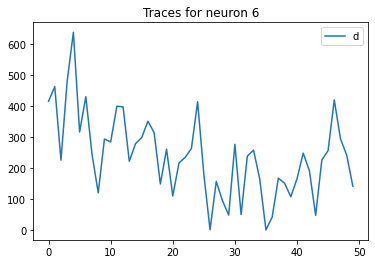

In [144]:
plt.plot(dnmf.C[0,:])
plt.legend('dNMF')
plt.title('Traces for neuron {}'.format(which_neuron))
plt.savefig('Traces for neuron {}'.format(which_neuron))

In [145]:
neuron_names = [str(i) for i in range(positions.shape[0])]

dnmf.visualize_neurons('Results3d_neuron{}'.format(which_neuron), [['0','1']], neuron_names, dat)

In [94]:
# dnmf.visualize_raw('result3d',dat)

# Scratch

In [66]:
xyz = np.append(this_xy[0], 13.0)
xyz

array([216.54124451, 332.24829102,  13.        ])

In [67]:
x_ind, y_ind, z_ind = get_crop_coords3d(xyz, (28,28,10))
z_ind

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [68]:
video = vid
video.shape

NameError: name 'vid' is not defined

In [ ]:
video[0:1,:,:,:].shape

In [40]:
video[0,:,:,:][z_ind,:,:][:, y_ind,:][:,:, x_ind].shape

(10, 28, 28)

In [8]:
vid = imageio.get_reader(fname,  'ffmpeg')

# Pre-allocate in proper size for future
sz = (50,50)
cropped_dat = np.zeros(sz+(1,num_frames))

for i, frame in enumerate(vid):
    if i >= num_frames:
        break

    x_ind, y_ind = get_crop_coords(this_xy[i], sz)
    cropped_dat[:,:,0,i] = frame[y_ind, x_ind, 0]
#     cropped_dat[:,:,0,i] = cv2.cvtColor(frame.astype('float32'), cv2.COLOR_BGR2GRAY)[y_ind, x_ind]